In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from scipy.stats import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier

In [2]:
data = pd.read_csv('./stroke_data.csv')
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
avg = data['bmi'].mean()
data.bmi = data.bmi.fillna(avg)

In [4]:
enc = LabelEncoder()
object_col = [col for col in data.columns if data[col].dtype == 'object']
for col in object_col:
    data[col] = enc.fit_transform(data[col])

data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,51676,0,61.0,0,0,1,3,0,202.21,28.893237,2,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.000000,2,1


In [5]:
#divide dataset into features and labels
#drop ID because it's not necessary for analysis
X = data.iloc[:, 1:-1]
y = data.loc[:, 'stroke']
X.gender = (X.gender.fillna(1))

/Users/kevinkarnani/.conda/envs/myenv/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


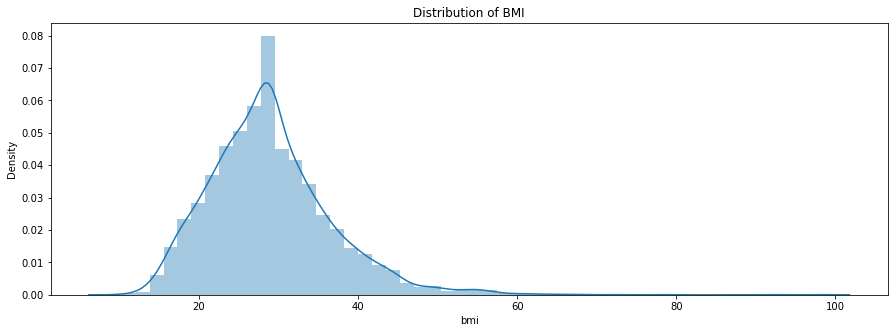

In [6]:
plt.subplots(figsize=(15, 5))
sns.distplot(data['bmi'])
plt.title('Distribution of BMI')
plt.show()

/Users/kevinkarnani/.conda/envs/myenv/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


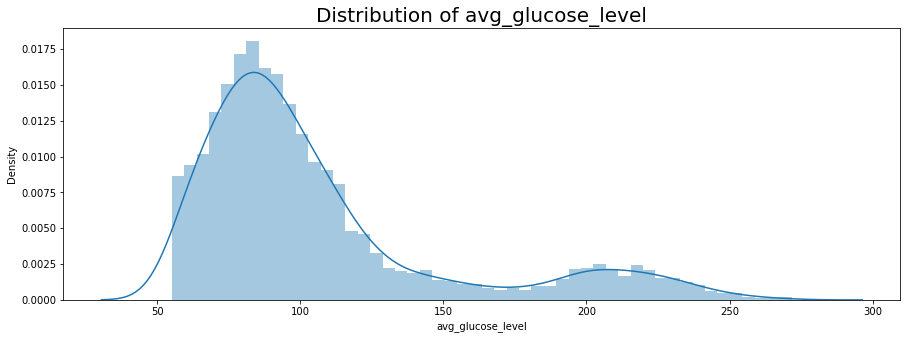

In [7]:
plt.subplots(figsize=(15, 5))
sns.distplot(data['avg_glucose_level'])
plt.title('Distribution of avg_glucose_level', fontsize=20)
plt.show()

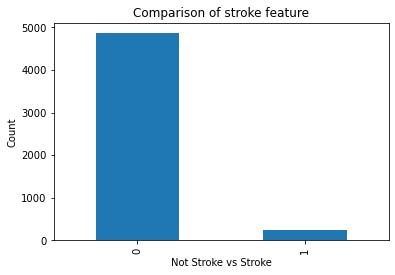

In [8]:
data['stroke'].value_counts(dropna=False).plot.bar()
plt.title('Comparison of stroke feature')
plt.xlabel('Not Stroke vs Stroke')
plt.ylabel('Count')
plt.show()

In [9]:
s_X = pd.DataFrame(StandardScaler().fit_transform(X.values))

print(f'Before OverSampling, counts of label \'1\': {sum(y == 1)}')
print(f'Before OverSampling, counts of label \'0\': {sum(y == 0)} \n')
s_X, y = SMOTE().fit_resample(s_X, y)
print(f'After OverSampling, counts of label \'1\': {sum(y == 1)}')
print(f'After OverSampling, counts of label \'0\': {sum(y == 0)}')
X_train, X_test, y_train, y_test = train_test_split(s_X, y, test_size=0.33, random_state=0)

Before OverSampling, counts of label '1': 249
Before OverSampling, counts of label '0': 4861 

After OverSampling, counts of label '1': 4861
After OverSampling, counts of label '0': 4861


In [10]:
def potential_splits(all_data, random_subspace):
    """Find all unique values to split on for all columns"""
    splits = {}
    cols = random.sample(population=list(all_data.columns[:-1]),
                         k=random_subspace) if random_subspace and random_subspace <= len(
        all_data.columns[:-1]) else all_data.columns[:-1]
    for col in cols:
        values = all_data.loc[:, col].unique()
        splits[col] = [(values[j] + values[j - 1]) / 2 for j in range(1, len(values))] if len(values) > 1 else [
            values[0]]
    return splits


def split_data(all_data, col, val):
    """Find data above and below value by given column"""
    return all_data[all_data.loc[:, col] > val], all_data[all_data.loc[:, col] <= val]


def entropy(all_data):
    """Find total entropy"""
    counts = all_data.loc[:, 'stroke'].value_counts()
    return -sum(counts / counts.sum() * np.log2(counts / counts.sum()))


def separate_entropy(data_above, data_below):
    """Find feature entropy"""
    n = len(data_above) * len(data_below) + np.finfo(float).eps
    return len(data_above) / n * entropy(data_above) + len(data_below) * entropy(data_below)


def find_best(all_data, splits):
    """Given all attributes, find feature entropy, and then find best feature"""
    overall_entropy = np.finfo(float).max
    best_col = best_val = None
    for col in splits:
        for val in splits[col]:
            above, below = split_data(all_data, col, val)
            current_entropy = separate_entropy(above, below)

            if current_entropy <= overall_entropy:
                overall_entropy = current_entropy
                best_col = col
                best_val = val
    return best_col, best_val

In [11]:
def id3(all_data, attributes, random_subspace=None):
    """Build the tree by recursing through all features"""
    y_data = all_data.loc[:, 'stroke']
    if all_data.empty:
        return stats.mode(y_train).mode[0]
    elif np.all(y_data) == 1:
        return y_data.values[0]
    elif len(attributes) == 1:
        return stats.mode(y_data).mode[0]
    splits = potential_splits(all_data, random_subspace)
    col, val = find_best(all_data, splits)
    above, below = split_data(all_data, col, val)
    feature = f'{col} <= {val}'
    subtree = {feature: []}
    new_attributes = np.delete(attributes, list(attributes).index(col))
    above = above.drop(col, axis=1)
    below = below.drop(col, axis=1)
    above = id3(above, new_attributes, random_subspace)
    below = id3(below, new_attributes, random_subspace)
    subtree[feature].append(below)
    subtree[feature].append(above)
    return subtree


all_data_train = X_train.copy()
all_data_train.loc[:, 'stroke'] = y_train
all_data_train.columns = data.columns[1:]

tree = id3(all_data_train, X.columns)

Accuracy: 0.7036459956372701
Precision: 0.6572237960339944
Recall: 0.8608534322820037
F-score: 0.7453815261044178


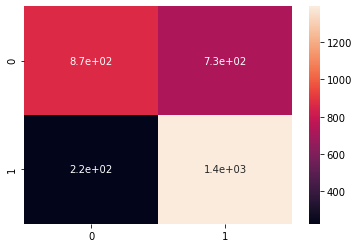

In [12]:
def classify_id3(example, root):
    """Based on tree, classify a single example"""
    feature = list(root.keys())[0]
    name, _, val = feature.split()
    ans = root[feature][0] if example[name] <= float(val) else root[feature][1]

    if not isinstance(ans, dict):
        return ans
    return classify_id3(example, ans)


def metrics_id3(all_data, root):
    """Apply id3 to whole dataframe and compute metrics"""
    y_pred = all_data.apply(classify_id3, axis=1, args=(root,))
    y_data = all_data.loc[:, 'stroke']
    print(f'Accuracy: {accuracy_score(y_data, y_pred)}')
    print(f'Precision: {precision_score(y_data, y_pred)}')
    print(f'Recall: {recall_score(y_data, y_pred)}')
    print(f'F-score: {f1_score(y_data, y_pred)}')
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
    plt.show()


all_data_test = X_test.copy()
all_data_test.loc[:, 'stroke'] = y_test
all_data_test.columns = data.columns[1:]

metrics_id3(all_data_test, tree)

<p>Having tested with binarized data vs splits on unique data...
it seems not only is binarized data faster, but it yields slightly better results.
For the sake of complexity later with the Random Forest implementation, it is  better to use split data.
</p>

In [13]:
def random_forest(all_data, attributes, n_trees, n_bootstrap, n_features):
    """Random Forest is just a list of decision trees using subsets of features and data"""
    return [id3(all_data.sample(n_bootstrap), attributes, random_subspace=n_features) for _ in range(n_trees)]


def classify_rf(all_data, roots):
    """Given a forest, classify all the examples in a dataframe"""
    return pd.DataFrame(
        {
            f'tree_{i}': all_data.apply(classify_id3, axis=1, args=(roots[i],)) for i in range(len(roots))
        }).mode(axis=1)[0]


forest = random_forest(all_data_train, X.columns, 10, 4000, 3)

Accuracy: 0.7120598317232782
Precision: 0.6665064872657376
Recall: 0.8577612863327149
F-score: 0.7501352082206597


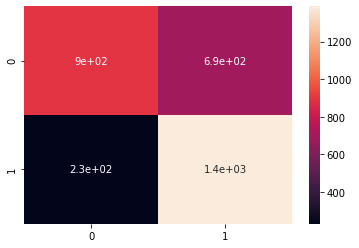

In [14]:
y_pred = classify_rf(all_data_test, forest)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F-score: {f1_score(y_test, y_pred)}')
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.show()

<p> As seen above, Random Forest has a slightly better fit on the data than ID3.
Although it does take significantly longer, so unless ID3's performance is improved,
this will not really help. Currently, ID3 takes around 30 secs, and RF around 2-3 mins.
</p>

Accuracy: 0.947335618572764
Precision: 0.937726723095526
Recall: 0.9591836734693877
F-score: 0.9483338428615102


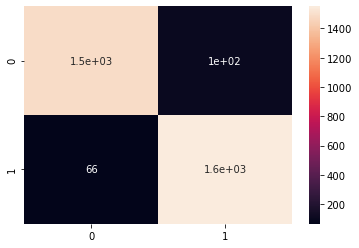

In [15]:
rf = RandomForestClassifier(class_weight='balanced', criterion='entropy')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred_rf)}')
print(f'Precision: {precision_score(y_test, y_pred_rf)}')
print(f'Recall: {recall_score(y_test, y_pred_rf)}')
print(f'F-score: {f1_score(y_test, y_pred_rf)}')

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True)
plt.show()

Accuracy: 0.8968526020567155
Precision: 0.8850299401197604
Recall: 0.9140383426097711
F-score: 0.899300273805902


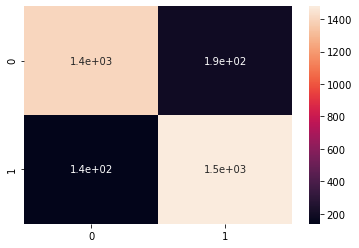

In [16]:
id3_tree = DecisionTreeClassifier(class_weight='balanced', criterion='entropy')
id3_tree.fit(X_train, y_train)
y_pred_id3 = id3_tree.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred_id3)}')
print(f'Precision: {precision_score(y_test, y_pred_id3)}')
print(f'Recall: {recall_score(y_test, y_pred_id3)}')
print(f'F-score: {f1_score(y_test, y_pred_id3)}')

sns.heatmap(confusion_matrix(y_test, y_pred_id3), annot=True)
plt.show()

Find which features are actually relevant when doing stroke prediction.

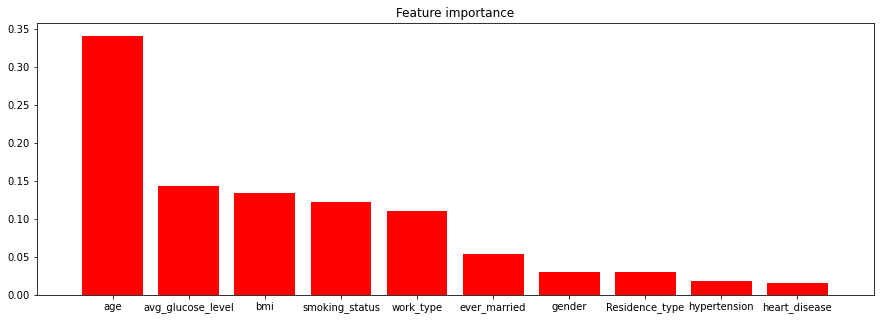

In [17]:
sel = SelectFromModel(rf)
sel.fit(X_train, y_train)
indices = np.argsort(sel.estimator_.feature_importances_)[::-1]
# X is the train data used to fit the model
plt.figure(figsize=(15, 5))
plt.title('Feature importance')
plt.bar(X.columns[indices], sel.estimator_.feature_importances_[indices], color='r', align='center')
plt.xlim([-1, X_train.shape[1]])
plt.show()